In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import socket
import sys

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']
%matplotlib inline

from __future__ import print_function

In [2]:
hostname=socket.gethostname()

if hostname=='alistair-pc70':
    sqluser = 'alistairewj'
else:
    sqluser = 'postgres'

dbname = 'mimic'
schema_name = 'mimiciii'
query_schema = 'SET search_path to public,' + schema_name + ';'

In [3]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)

In [4]:
# exclusion criteria:
#   - less than 16 years old
#   - never have any chartevents data (i.e. likely administrative error)
#   - not cardiac surgery
#   - suspected of infection
#   - first ICU stay

query = query_schema + "select * from mpwr_cohort"

co = pd.read_sql_query(query,con)

In [5]:
# print out the exclusions
N = co.shape[0]
print('Cohort - initial size: {} ICU stays'.format(N))
idxRem = np.zeros(co.shape[0],dtype=bool)

# apply adult exclusions
c = "exclusion_nonadult"
if c in co.columns:
    print('  {:5g} ({:2.2f}%) - {}'.format(np.sum(co[c]),np.sum(co[c])*100.0/N, c))
    print('')
    idxRem[co[c].values==1] = True
    co = co.loc[~idxRem,:]
    N = co.shape[0]
    idxRem = np.zeros(co.shape[0],dtype=bool)
    print('Cohort - adults: {} ICU stays'.format(N))
    
for c in co.columns:
    if c.startswith('exclusion_'):
        print('  {:5g} ({:2.2f}%) - {}'.format(np.sum(co[c]),np.sum(co[c])*100.0/N, c))
        idxRem[co[c].values==1] = 1
        
print('Final cohort size: {} ICU stays ({:2.2f}%).'.format(N - np.sum(idxRem), (1-np.mean(idxRem))*100.0))

Cohort - initial size: 61532 ICU stays
   8109 (13.18%) - exclusion_nonadult

Cohort - adults: 53423 ICU stays
      0 (0.00%) - exclusion_nonadult
  14826 (27.75%) - exclusion_readmission
   1480 (2.77%) - exclusion_trach
  28471 (53.29%) - exclusion_not_vent
  46142 (86.37%) - exclusion_not_vent_48hr
    468 (0.88%) - exclusion_bad_data
Final cohort size: 5003 ICU stays (9.36%).


In [6]:
# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Sequentially remove patients...\n')
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))

COL_REM = ['exclusion_readmission', 'exclusion_not_vent_48hr','exclusion_trach','exclusion_bad_data']

idxRem = np.zeros(co.shape[0])
for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/co.shape[0], c))
    idxRem[co[c].values==1] = 1
        
print('Final cohort size: {} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))
print('')

Sequentially remove patients...

Cohort - initial size: 53423 ICU stays
  14826 (27.75%) - exclusion_readmission
  33384 (62.49%) - exclusion_not_vent_48hr
    210 (0.39%) - exclusion_trach
      0 (0.00%) - exclusion_bad_data
Final cohort size: 5003.0 ICU stays (9.36%).



In [7]:
# load in final dataset (already has exclusion criteria applied)
query = query_schema + "select * from mpwr_data"

df = pd.read_sql_query(query,con)
df.columns

Index([u'icustay_id', u'height', u'weight', u'smoking', u'gender', u'age',
       u'admission_type', u'source_of_admission', u'insurance',
       u'marital_status',
       ...
       u'peak_insp_pressure_max_day2', u'resp_rate_set_min_day2',
       u'resp_rate_set_max_day2', u'resp_rate_total_min_day2',
       u'resp_rate_total_max_day2', u'fio2_min_day2', u'fio2_max_day2',
       u'ventmode_day2', u'rrtfirstday', u'ventfirstday'],
      dtype='object', length=120)

We have: ICU intime/outtime, suspected infection time, whether the microbiology culture was positive, some demographics, comorbidities, outcomes, and the severity scores. 

The severity scores are extracted at a [0, 24] hour window centered around ICU admission - except labs have an extended [-6, 24] hour window (i.e. 'sofa' is extracted in this way).

# Vent duration

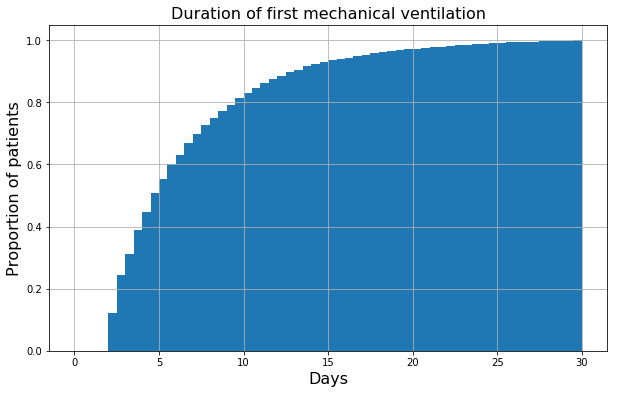

In [8]:
# distribution of time of infection
xi = np.linspace(0, 30, 30*2+1)

idxKeep = np.ones(df.shape[0], dtype=bool)
tmp = df.loc[idxKeep,'duration_first_vent_days']
# to calc hours from dates: (df.loc[idxKeep,'suspected_infection_time'] - df.loc[idxKeep,'intime']).values / np.timedelta64(1, 'h')

plt.figure(figsize=[10,6])
plt.hist( tmp, bins=xi, normed=True, cumulative=True )
plt.title('Duration of first mechanical ventilation',fontsize=16)
plt.ylabel('Proportion of patients',fontsize=16)
plt.xlabel('Days',fontsize=16)
plt.grid()
plt.show()

In [9]:
# calculate how many had ARDS
N = df.shape[0]

# report on % with suspicion of infection
print('Of the total {} stays, {} had ARDS {:2.2f}%.'.format(
        N,
        np.sum(df.ards > 0),
        np.sum(df.ards > 0).astype(float)*100.0 / N
    ))

Of the total 5003 stays, 531 had ARDS 10.61%.


# Save the data to file

The dataframes will be loaded directly from a file, rather than the database.

The `X` data which was written to 'sepsis3-design-matrix.csv' will be used by the `print_auc_table_baseline` function to evaluate the AUROC of the scores when incorporated with the baseline model.

In [10]:
df.to_csv('mpwr_data.csv',sep=',',index=False)

In [11]:
con.close()